In [4]:
import sys
import os
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt 

# Setup paths
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.explainers.lime_text import LimeTextExplainer # Assumes this exists from previous steps
from src.core.sp_lime import SubmodularPick

def run_experiment():
    print("--- Reproducing Section 6.2: Trusting the Model (Text) ---")
    
    # 1. Load Data
    categories = ['alt.atheism', 'soc.religion.christian']
    print("Loading 20 Newsgroups data (Train/Test)...")
    newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
    newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
    
    # 2. Train an "Untrustworthy" Classifier
    print("Training SVM on raw text (including artifacts)...")
    vectorizer = TfidfVectorizer(lowercase=False) 
    clf = SVC(probability=True, kernel='linear')
    pipeline = make_pipeline(vectorizer, clf)
    pipeline.fit(newsgroups_train.data, newsgroups_train.target)
    
    acc = pipeline.score(newsgroups_test.data, newsgroups_test.target)
    print(f"Test Accuracy: {acc:.2f}")
    
    # 3. Generate LIME Explanations for a Batch
    N_SAMPLES = 30
    print(f"\nGenerating LIME explanations for {N_SAMPLES} random instances...")
    
    indices = np.random.choice(len(newsgroups_test.data), N_SAMPLES, replace=False)
    text_data = [newsgroups_test.data[i] for i in indices]
    
    explainer = LimeTextExplainer(random_state=42)
    explanations = []
    
    for i, text in enumerate(text_data):
        probs = pipeline.predict_proba([text])[0]
        pred_class = np.argmax(probs)
        
        # Explain the PREDICTED class
        exp = explainer.explain_instance(
            text, 
            pipeline.predict_proba, 
            labels=(pred_class,), 
            num_features=5,
            num_samples=200 
        )
        # Store target class name for later visualization
        exp[pred_class]['target_class_name'] = newsgroups_train.target_names[pred_class]
        explanations.append(exp[pred_class])
        
        sys.stdout.write(f"\rExplained {i+1}/{N_SAMPLES}")
        sys.stdout.flush()
        
    # 4. Run Submodular Pick
    print("\n\n--- Running Submodular Pick (Budget = 4) ---")
    sp = SubmodularPick(explanations, num_features_to_select=5)
    selected_indices = sp.pick_instances(budget_B=4)
    
    print(f"SP-LIME selected instances indices: {selected_indices}")
    
    # 5. Print Text Analysis
    print("\n--- TEXT ANALYSIS ---")
    suspicious_keywords = ['host', 'nntp', 'edu', 'organization', 'path', '@']
    
    for i, idx in enumerate(selected_indices):
        exp = explanations[idx]
        print(f"\n[Instance {i+1}] Pred: {exp['target_class_name']}")
        for feature, weight in exp['explanation_map']:
            is_artifact = any(x in feature.lower() for x in suspicious_keywords)
            marker = "  <-- SUSPICIOUS" if is_artifact else ""
            print(f"  {feature:>20} : {weight:.4f} {marker}")

    # 6. VISUALIZE AND SAVE IMAGE
    print("\n--- SAVING VISUALIZATION ---")
    save_path = "sp_lime_text_results.png"
    
    # Setup plot: 1 row, 4 columns (since budget is 4)
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))
    plt.suptitle("SP-LIME: Representative Explanations (Suspect features like 'Organization' reveal data leakage)", fontsize=16)

    for i, idx in enumerate(selected_indices):
        ax = axes[i]
        exp = explanations[idx]
        
        # Get data: features and weights
        # We reverse them so the highest weight is at the top of the bar chart
        data = exp['explanation_map'][::-1] 
        features = [x[0] for x in data]
        weights = [x[1] for x in data]
        
        # Color coding: Green for positive contribution, Red for negative
        colors = ['green' if w > 0 else 'red' for w in weights]
        
        # Create horizontal bar chart
        ax.barh(features, weights, color=colors)
        ax.set_title(f"Instance #{idx}\nPred: {exp['target_class_name']}", fontsize=12, fontweight='bold')
        ax.set_xlabel("Feature Importance")
        
        # Check for artifacts to highlight the subplot border (Optional visual flair)
        if any(any(k in f.lower() for k in suspicious_keywords) for f in features):
            # Highlight axis border in red if suspicious
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(2)
            ax.set_xlabel("Importance (Contains Artifacts!)", color='red', fontweight='bold')

    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Visualization saved to '{save_path}'")


--- Reproducing Section 6.2: Trusting the Model (Text) ---
Loading 20 Newsgroups data (Train/Test)...
Training SVM on raw text (including artifacts)...
Test Accuracy: 0.95

Generating LIME explanations for 30 random instances...
Explained 30/30

--- Running Submodular Pick (Budget = 4) ---
SP-LIME selected instances indices: [29, 21, 14, 22]

--- TEXT ANALYSIS ---

[Instance 1] Pred: alt.atheism
                  cobb : 0.1806 
                alexia : 0.1483 
                 taxes : 0.1408 
                   lis : 0.0895 
            measurable : 0.0402 

[Instance 2] Pred: alt.atheism
                    uk : 0.1526 
                     I : 0.1132 
            efficiency : 0.1055 
                 place : 0.0778 
                  This : 0.0374 

[Instance 3] Pred: alt.atheism
           responsible : 0.1548 
               between : 0.1035 
              disagree : 0.0963 
                  than : 0.0660 
                     a : 0.0518 

[Instance 4] Pred: alt.atheism
          

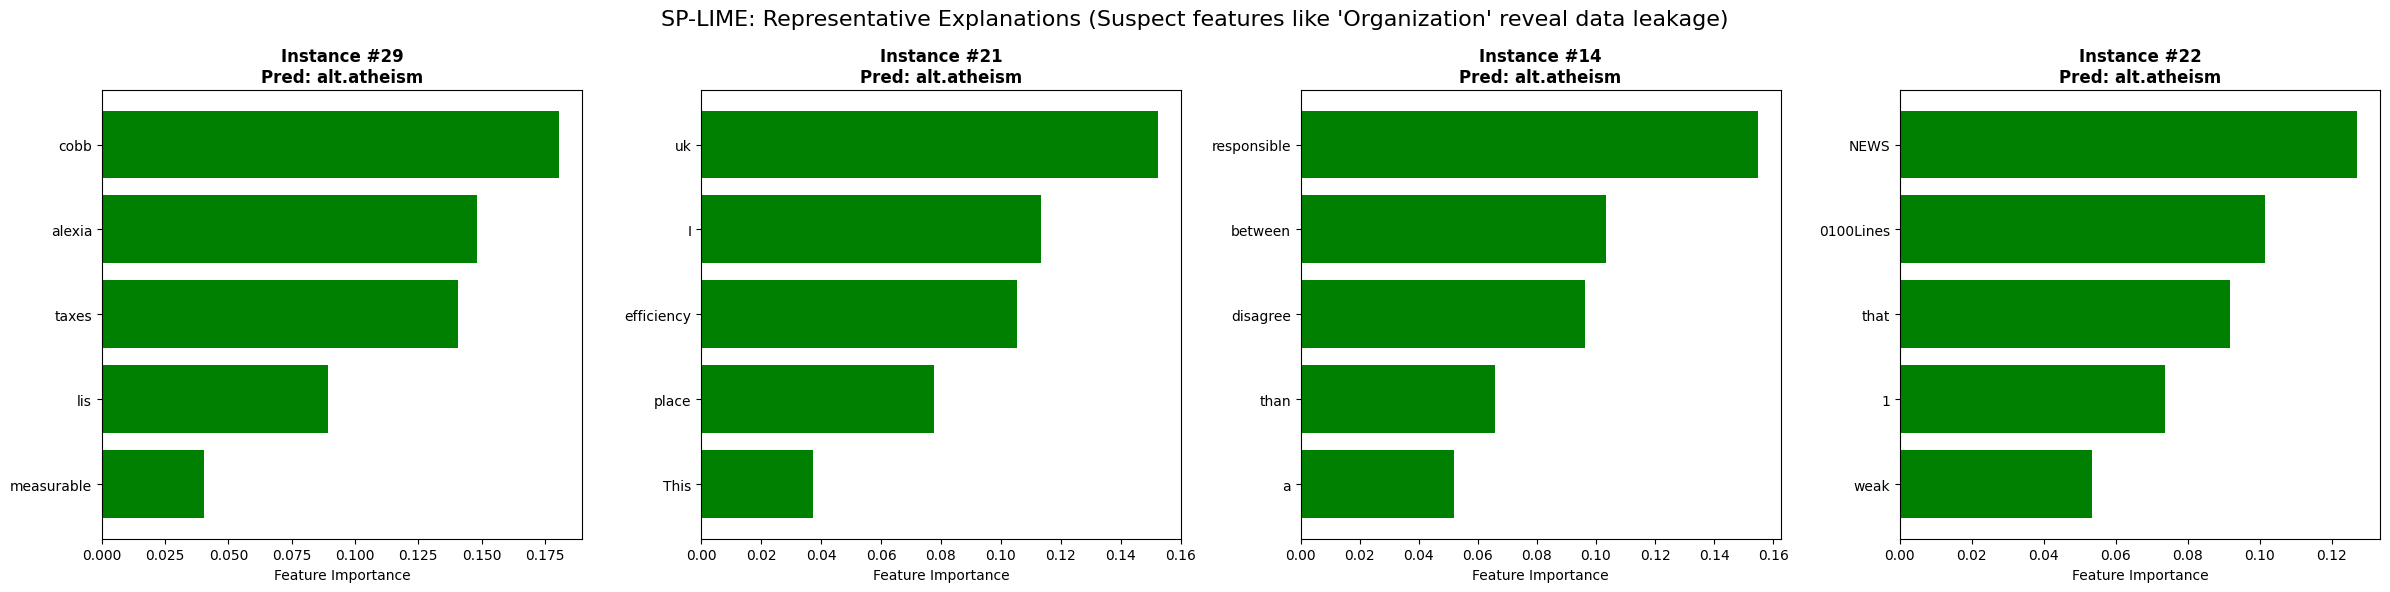

In [5]:

run_experiment()